# PyTorch BERT Multi-Model Trainer + KFolds🎯

📌 KFolds Inference (Submission) Notebook : https://www.kaggle.com/heyytanay/inference-0-6-lb-vanilla-pytorch-bert-starter

📌 My EDA and Multi Linear Models Notebook: https://www.kaggle.com/heyytanay/commonlit-readability-eda-multi-models

In [12]:
import os
import platform
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import transformers
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.simplefilter('ignore')

In [13]:
class Config:
    NB_EPOCHS = 10
    LR = 1e-6
    MAX_LEN = 185
    N_SPLITS = 5
    TRAIN_BS = 16
    VALID_BS = 32
    MODEL_NAME = 'distilbert-base-uncased'
    FILE_NAME = '../input/commonlitreadabilityprize/train.csv'
    TOKENIZER = transformers.DistilBertTokenizer.from_pretrained(MODEL_NAME, do_lower_case=True)
    scaler = GradScaler()

In [14]:
class BERTDataset(Dataset):
    def __init__(self, review, target=None, is_test=False):
        self.review = review
        self.target = target
        self.is_test = is_test
        self.tokenizer = Config.TOKENIZER
        self.max_len = Config.MAX_LEN
    
    def __len__(self):
        return len(self.review)
    
    def __getitem__(self, idx):
        review = str(self.review[idx])
        review = ' '.join(review.split())
        global inputs
        
        inputs = self.tokenizer.encode_plus(
            review,
            None,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True
        )        
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long)
        
        if self.is_test:
            return {
                'ids': ids,
                'mask': mask,
            }
        else:    
            targets = torch.tensor(self.target[idx], dtype=torch.float)
            return {
                'ids': ids,
                'mask': mask,
                'targets': targets
            }

In [15]:
class Trainer:
    def __init__(
        self, 
        model, 
        optimizer, 
        scheduler, 
        train_dataloader, 
        valid_dataloader,
        device
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_data = train_dataloader
        self.valid_data = valid_dataloader
        self.loss_fn = self.yield_loss
        self.device = device
        
    def yield_loss(self, outputs, targets):
        """
        This is the loss function for this task
        """
        return torch.sqrt(nn.MSELoss()(outputs, targets))
    
    def train_one_epoch(self):
        """
        This function trains the model for 1 epoch through all batches
        """
        prog_bar = tqdm(enumerate(self.train_data), total=len(self.train_data))
        self.model.train()
        all_losses = []
        with autocast():
            for idx, inputs in prog_bar:
                ids = inputs['ids'].to(self.device, dtype=torch.long)
                mask = inputs['mask'].to(self.device, dtype=torch.long)
                targets = inputs['targets'].to(self.device, dtype=torch.float)

                outputs = self.model(ids=ids, mask=mask).view(-1)

                loss = self.loss_fn(outputs, targets)
                prog_bar.set_description('loss: {:.2f}'.format(loss.item()))
                all_losses.append(loss.item())

                Config.scaler.scale(loss).backward()
                Config.scaler.step(self.optimizer)
                Config.scaler.update()
                self.optimizer.zero_grad()
                self.scheduler.step()
        
        train_loss = sum(all_losses) / len(all_losses)
        return train_loss
        
    
    def valid_one_epoch(self):
        """
        This function validates the model for one epoch through all batches of the valid dataset
        It also returns the validation Root mean squared error for assesing model performance.
        """
        prog_bar = tqdm(enumerate(self.valid_data), total=len(self.valid_data))
        self.model.eval()
        all_targets = []
        all_predictions = []
        with torch.no_grad():
            for idx, inputs in prog_bar:
                ids = inputs['ids'].to(self.device, dtype=torch.long)
                mask = inputs['mask'].to(self.device, dtype=torch.long)
                targets = inputs['targets'].to(self.device, dtype=torch.float)

                outputs = self.model(ids=ids, mask=mask).view(-1)
                all_targets.extend(targets.cpu().detach().numpy().tolist())
                all_predictions.extend(outputs.cpu().detach().numpy().tolist())

        val_rmse_loss = np.sqrt(mean_squared_error(all_targets, all_predictions))
        print('Validation RMSE: {:.2f}'.format(val_rmse_loss))
        
        return val_rmse_loss
    
    def get_model(self):
        return self.model

In [16]:
# Model
class DBERT_BASE_UNCASED(nn.Module):
    def __init__(self):
        super(DBERT_BASE_UNCASED, self).__init__()
        self.dbert = transformers.DistilBertModel.from_pretrained(Config.MODEL_NAME)
        self.drop = nn.Dropout(0.2)
        self.out = nn.Linear(768, 1)
    
    def forward(self, ids, mask):
        output = self.dbert(ids, attention_mask=mask)
        output = self.drop(output[0][:,0,:])
        output = self.out(output)
        return output

In [17]:
def yield_optimizer(model):
    """
    Returns optimizer for specific parameters
    """
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [
                p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.003,
        },
        {
            "params": [
                p for n, p in param_optimizer if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]
    return transformers.AdamW(optimizer_parameters, lr=Config.LR)

In [19]:
# Training Code
if __name__ == '__main__':
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device('cuda:0')
    else:
        print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
        DEVICE = torch.device('cpu')
        
    os.makedirs("./states_list", exist_ok=True)
    
    data = pd.read_csv(Config.FILE_NAME)
    data = data.sample(frac=1).reset_index(drop=True)
    data = data[['excerpt', 'target']]
    
    # Do Kfolds training and cross validation
    kf = StratifiedKFold(n_splits=Config.N_SPLITS)
    nb_bins = int(np.floor(1 + np.log2(len(data))))
    data.loc[:, 'bins'] = pd.cut(data['target'], bins=nb_bins, labels=False)
    
    train_losses = [{} for _ in range(Config.N_SPLITS)]
    val_losses = [{} for _ in range(Config.N_SPLITS)]
    
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X=data, y=data['bins'].values)):
        print(f"\nFold: {fold}")
        print(f"{'-'*20}\n")
        
        train_data = data.loc[train_idx]
        valid_data = data.loc[valid_idx]
        
        train_set = BERTDataset(
            review = train_data['excerpt'].values,
            target = train_data['target'].values
        )

        valid_set = BERTDataset(
            review = valid_data['excerpt'].values,
            target = valid_data['target'].values
        )

        train = DataLoader(
            train_set,
            batch_size = Config.TRAIN_BS,
            shuffle = True,
            num_workers=8
        )

        valid = DataLoader(
            valid_set,
            batch_size = Config.VALID_BS,
            shuffle = False,
            num_workers=8
        )

        model = DBERT_BASE_UNCASED().to(DEVICE)
        nb_train_steps = int(len(train_data) / Config.TRAIN_BS * Config.NB_EPOCHS)
        optimizer = yield_optimizer(model)
        scheduler = transformers.get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=nb_train_steps
        )

        trainer = Trainer(model, optimizer, scheduler, train, valid, DEVICE)

        best_loss = 100
        for epoch in range(1, Config.NB_EPOCHS+1):
            print(f"\n{'--'*5} EPOCH: {epoch} {'--'*5}\n")

            # Train for 1 epoch
            train_loss = trainer.train_one_epoch()
            train_losses[fold][epoch] = train_loss

            # Validate for 1 epoch
            current_loss = trainer.valid_one_epoch()
            val_losses[fold][epoch] = current_loss

            if current_loss < best_loss:
                print(f"Saving best model in this fold: {current_loss:.4f}")
                torch.save(trainer.get_model().state_dict(), f"./states_list/{Config.MODEL_NAME}_fold_{fold}.pt")
                best_loss = current_loss
        
        print(f"Best RMSE in fold: {fold} was: {best_loss:.4f}")
        print(f"Final RMSE in fold: {fold} was: {current_loss:.4f}")

[INFO] Using GPU: Tesla P100-PCIE-16GB


Fold: 0
--------------------


---------- EPOCH: 1 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 1.01
Saving best model in this fold: 1.0112

---------- EPOCH: 2 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.84
Saving best model in this fold: 0.8370

---------- EPOCH: 3 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.74
Saving best model in this fold: 0.7353

---------- EPOCH: 4 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.69
Saving best model in this fold: 0.6895

---------- EPOCH: 5 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.67
Saving best model in this fold: 0.6681

---------- EPOCH: 6 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.65
Saving best model in this fold: 0.6465

---------- EPOCH: 7 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.66

---------- EPOCH: 8 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.65

---------- EPOCH: 9 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.64
Saving best model in this fold: 0.6399

---------- EPOCH: 10 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.64
Best RMSE in fold: 0 was: 0.6399
Final RMSE in fold: 0 was: 0.6409

Fold: 1
--------------------


---------- EPOCH: 1 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.93
Saving best model in this fold: 0.9260

---------- EPOCH: 2 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.76
Saving best model in this fold: 0.7622

---------- EPOCH: 3 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.69
Saving best model in this fold: 0.6947

---------- EPOCH: 4 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.68
Saving best model in this fold: 0.6844

---------- EPOCH: 5 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.66
Saving best model in this fold: 0.6632

---------- EPOCH: 6 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.65
Saving best model in this fold: 0.6495

---------- EPOCH: 7 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.66

---------- EPOCH: 8 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.64
Saving best model in this fold: 0.6430

---------- EPOCH: 9 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.64
Saving best model in this fold: 0.6357

---------- EPOCH: 10 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.63
Saving best model in this fold: 0.6342
Best RMSE in fold: 1 was: 0.6342
Final RMSE in fold: 1 was: 0.6342

Fold: 2
--------------------


---------- EPOCH: 1 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.99
Saving best model in this fold: 0.9930

---------- EPOCH: 2 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.88
Saving best model in this fold: 0.8765

---------- EPOCH: 3 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.76
Saving best model in this fold: 0.7577

---------- EPOCH: 4 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.71
Saving best model in this fold: 0.7084

---------- EPOCH: 5 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.69
Saving best model in this fold: 0.6914

---------- EPOCH: 6 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.68
Saving best model in this fold: 0.6794

---------- EPOCH: 7 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.67
Saving best model in this fold: 0.6735

---------- EPOCH: 8 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.67
Saving best model in this fold: 0.6681

---------- EPOCH: 9 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.66
Saving best model in this fold: 0.6638

---------- EPOCH: 10 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.66
Best RMSE in fold: 2 was: 0.6638
Final RMSE in fold: 2 was: 0.6649

Fold: 3
--------------------


---------- EPOCH: 1 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.96
Saving best model in this fold: 0.9596

---------- EPOCH: 2 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.79
Saving best model in this fold: 0.7923

---------- EPOCH: 3 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.69
Saving best model in this fold: 0.6935

---------- EPOCH: 4 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.66
Saving best model in this fold: 0.6581

---------- EPOCH: 5 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.64
Saving best model in this fold: 0.6432

---------- EPOCH: 6 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.63
Saving best model in this fold: 0.6320

---------- EPOCH: 7 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.62
Saving best model in this fold: 0.6171

---------- EPOCH: 8 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.61
Saving best model in this fold: 0.6145

---------- EPOCH: 9 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.62

---------- EPOCH: 10 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.62
Best RMSE in fold: 3 was: 0.6145
Final RMSE in fold: 3 was: 0.6180

Fold: 4
--------------------


---------- EPOCH: 1 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.97
Saving best model in this fold: 0.9725

---------- EPOCH: 2 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.82
Saving best model in this fold: 0.8237

---------- EPOCH: 3 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.71
Saving best model in this fold: 0.7095

---------- EPOCH: 4 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.67
Saving best model in this fold: 0.6731

---------- EPOCH: 5 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.66
Saving best model in this fold: 0.6635

---------- EPOCH: 6 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.65
Saving best model in this fold: 0.6544

---------- EPOCH: 7 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.64
Saving best model in this fold: 0.6412

---------- EPOCH: 8 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.64

---------- EPOCH: 9 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.64

---------- EPOCH: 10 ----------



  0%|          | 0/142 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Validation RMSE: 0.64
Saving best model in this fold: 0.6372
Best RMSE in fold: 4 was: 0.6372
Final RMSE in fold: 4 was: 0.6372


<AxesSubplot:title={'center':'Train'}>

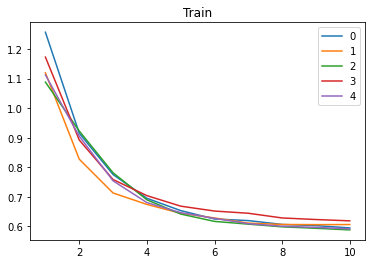

In [20]:
pd.DataFrame(train_losses).T.plot(title="Train")

<AxesSubplot:title={'center':'Val'}>

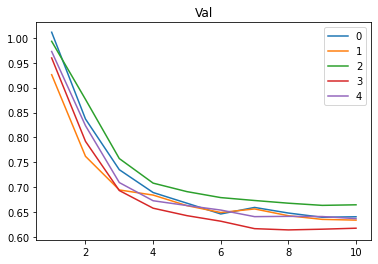

In [21]:
pd.DataFrame(val_losses).T.plot(title="Val")